# House Prices Prediction using Stacking Modeling

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

# Statistical library
from scipy import stats
from scipy.stats import norm, skew 

# Missing value visualization
import missingno as msno

# Seaborn configuration style
sns.set_style("darkgrid")

# Import data

## Training data

In [39]:
# Read data
dataset = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
# Dataset dimensions
print(f"Shape of the dataset: {dataset.shape}")
# Show data sample
dataset.head()

Shape of the dataset: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Test data

In [ ]:
# Read data
test_dataset = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
# Dataset dimensions
print(f"Shape of the test_dataset: {test_dataset.shape}")
# Show data sample
test_dataset.head()

# Exploration Data Analysis (EDA)

### Check duplicated Ids

In [40]:
print("There are {0} duplicated Ids".format(dataset['Id'].duplicated().sum()))
# Drop Id column
dataset = dataset.drop(['Id'], axis=1)

There are 0 duplicated Ids


### Check dataset dtype

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Exploring Sale Price column

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Density'>

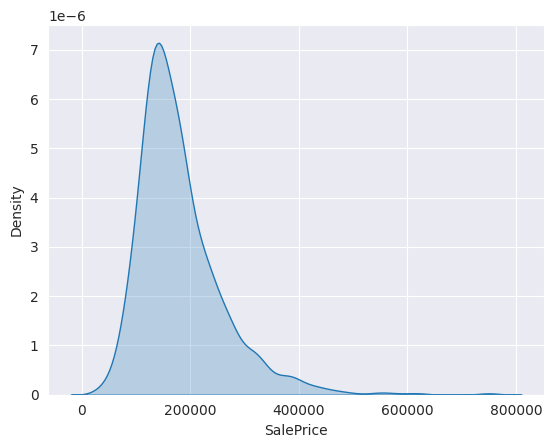

In [37]:
# Distribution of the sale price column
sns.kdeplot(
    data=dataset,
    x="SalePrice",    
    fill=True    
)

<p style="font-size:16px;">
The Sale Price column is right skewed. The proper form to treat this type of variables with linear models is convert the data to normally distributed data. When the data is 
</p>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


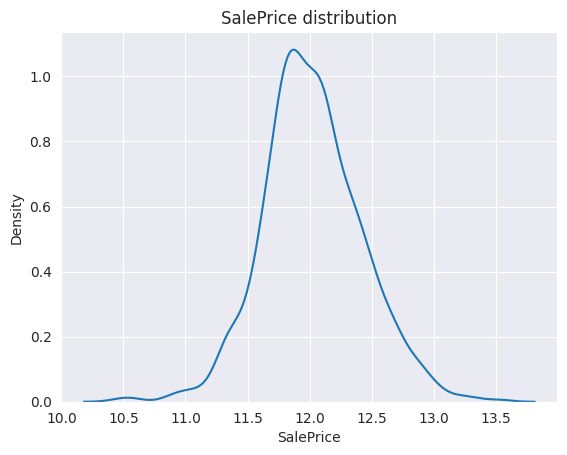

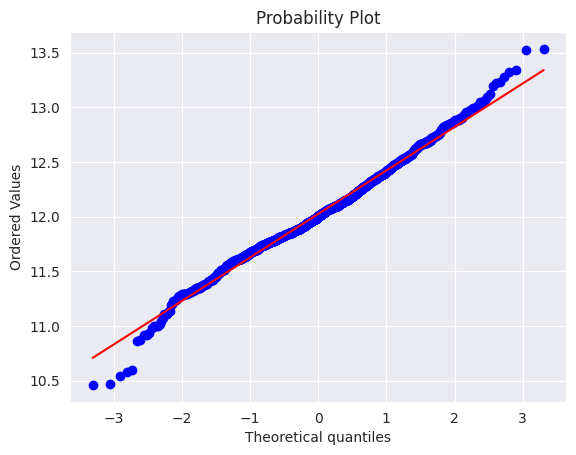

In [41]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
dataset['SalePrice'] = np.log1p(dataset['SalePrice'])

#Check the new distribution 
sns.kdeplot(dataset['SalePrice'])
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(dataset['SalePrice'], plot=plt)
plt.show()

## Missing values

<Axes: >

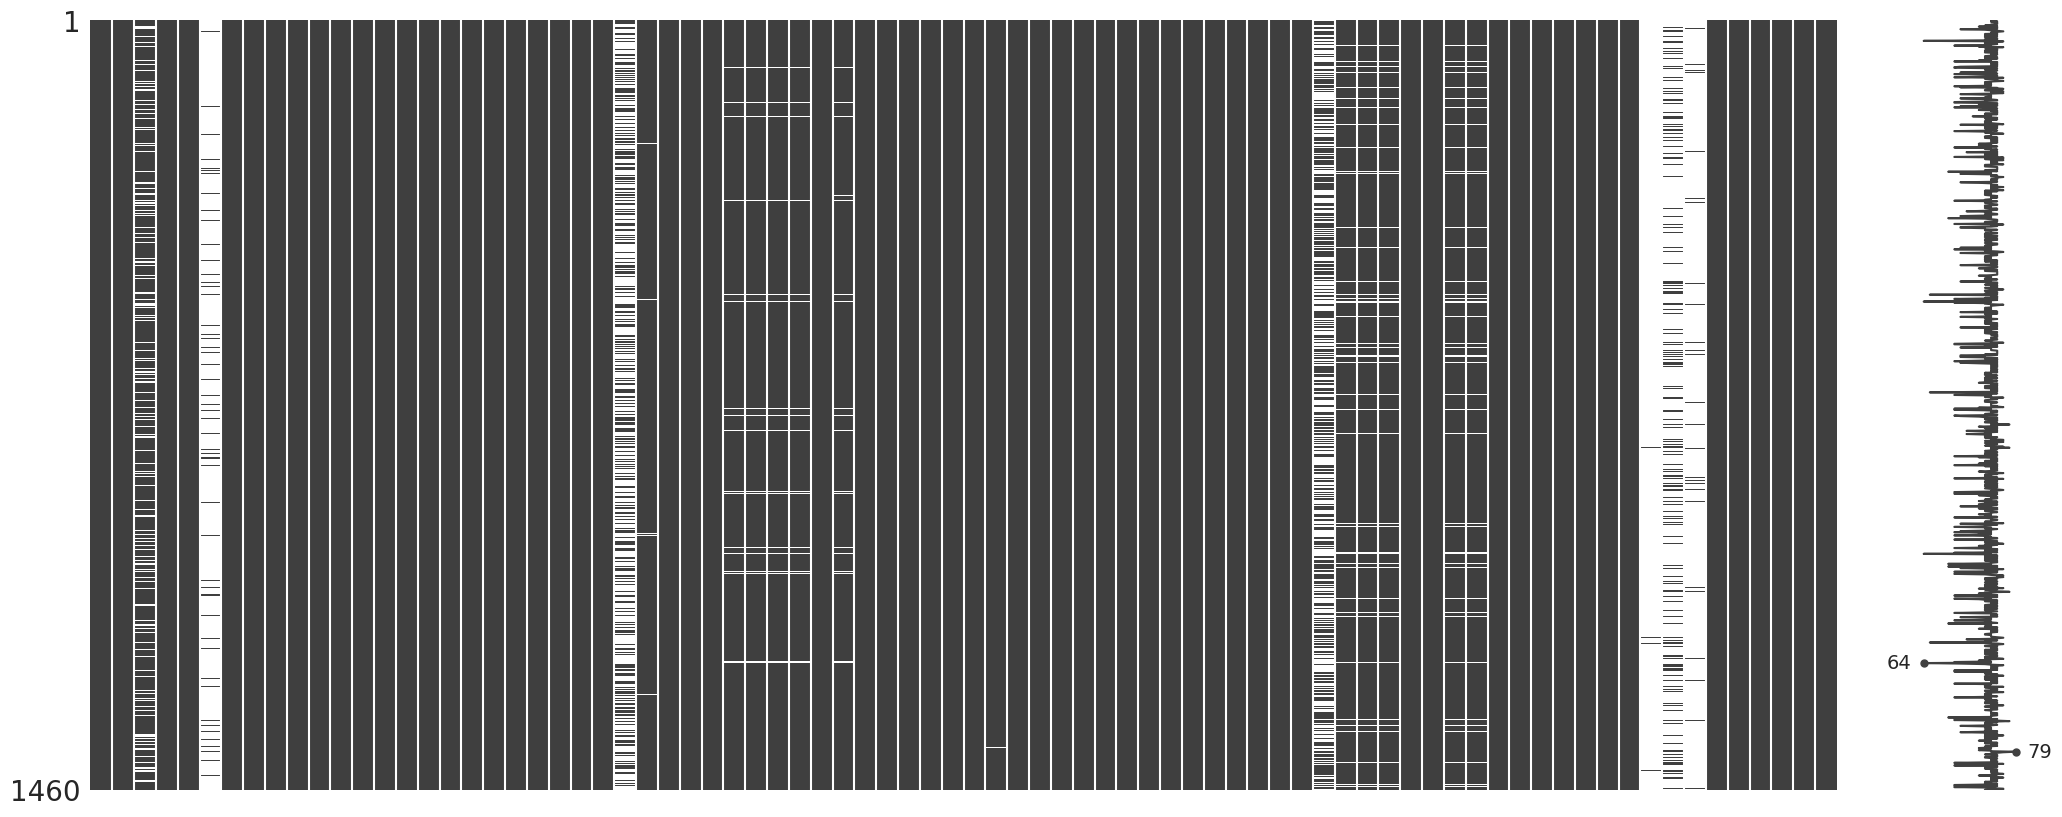

In [5]:
# Visualize missing values
msno.matrix(dataset)

In [6]:
# Check the columns with missing values
print(dataset.columns[dataset.isna().sum() > 0])

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


<p style="font-size:16px;">According to the dataset description, missing data appears in columns where a category of "No ..." or something similar exists. Also, when the categorical columns "GarageType" does not contain "Garage", or when the column "MasVnrType" contains "None", the values for "GarageYrBlt" and "MasVnrArea" are set to 0, rather than being considered as missing values.</p>

In [7]:
# Categorical columns where missing values were found
target_missing_columns = {
    "Alley": "No Alley",
    "LotFrontage": 0.0,
    "MasVnrType": "None",
    "BsmtQual": "No basement",
    "BsmtCond": "No basement",
    "BsmtExposure": "No basement",
    "BsmtFinType1": "No basement",
    "BsmtFinType2": "No basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None"
}
# Dependent columns
missing_dependent_columns = {
    "MasVnrArea": ["MasVnrType", "None"],
    "GarageYrBlt": ["GarageType", "No Garage"]    
}

### Handling missing categories

In [8]:
for column, fill_value in target_missing_columns.items():    
    dataset[column] = dataset[column].fillna(fill_value)  

### Handling missing values of dependent columns

In [9]:
for dependent_column, (column, value) in missing_dependent_columns.items():
    dataset.loc[dataset[column] == value, dependent_column] = 0    

### Drop the missing values from the "Electrical" column

In [10]:
dataset = dataset.dropna(subset=["Electrical"])
dataset = dataset.reset_index(drop=True)

<Axes: >

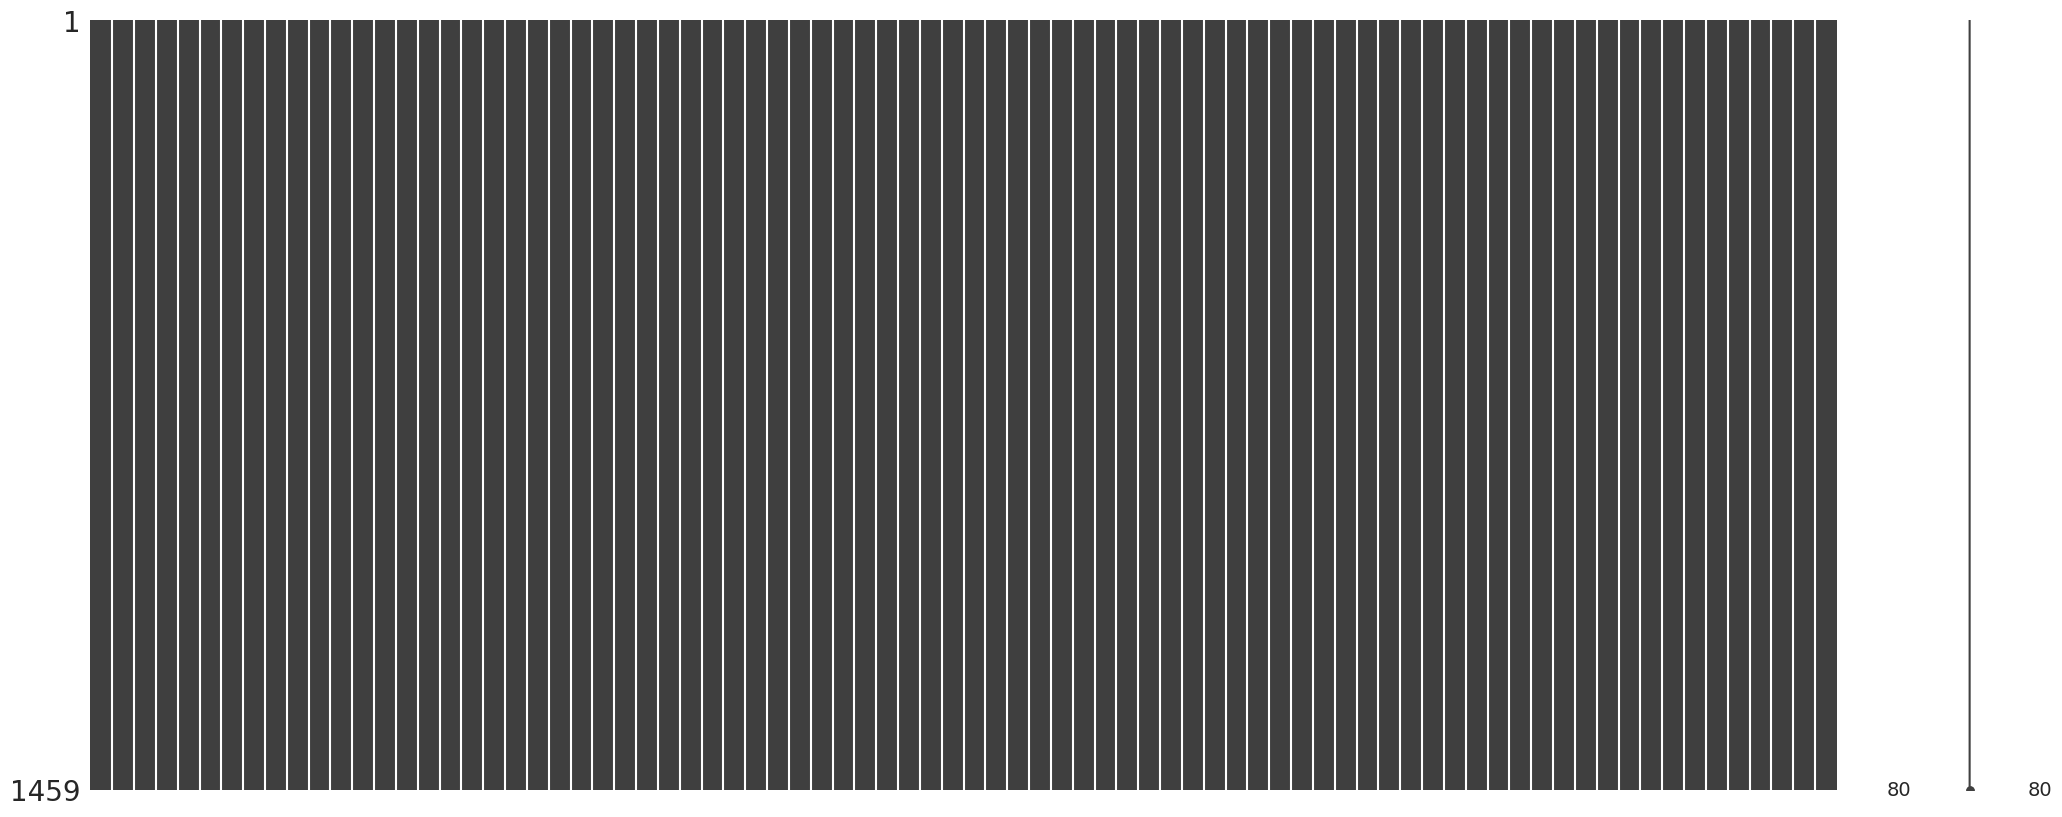

In [11]:
# Visualize missing values
msno.matrix(dataset)

## Correction of fields

Convert all the categorical columns to object type

In [12]:
categorical_columns = (
    "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", \
    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", \
    "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", \
    "KitchenQual", "Functional", \
    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", \
    "MiscFeature", "YrSold", "SaleType", "SaleCondition"    
)
auto_label_encoder = [
    "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", \
    "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", \
    "Fireplaces", "GarageCars", "MoSold"
]

In [13]:
dataset[list(auto_label_encoder)].dtypes

OverallQual     int64
OverallCond     int64
BsmtFullBath    int64
BsmtHalfBath    int64
FullBath        int64
HalfBath        int64
BedroomAbvGr    int64
KitchenAbvGr    int64
TotRmsAbvGrd    int64
Fireplaces      int64
GarageCars      int64
MoSold          int64
dtype: object

In [14]:
def change_dtype(dataset, column, type):
    """
        To change the type of the columns of the dataset
        Args:
            dataset (pandas DataFrame)
            column (string): Columns to change
            type (string): New type for the columns
    """
    return dataset[column].astype(type)

# Convert to the right type
for cat_column in categorical_columns:
    dataset[cat_column] = change_dtype(dataset, cat_column, "object")

In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   object 
 1   MSZoning       1459 non-null   object 
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

# Preprocessing Data

In [ ]:
# Get the features and labels
X_train = dataset.iloc[:, :-1]
y_train = dataset.iloc[:, -1]

## Convert to Label Encoder

Label Encoder can be useful in categorical variables that give some notion of ordinal sort, ratings or categorical values represented as numbers

In [ ]:
# List of categorical columns to Label Encoder
target_le_columns = (
    "MSSubClass", "LotShape", "LandContour", "LandSlope", \
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", \
    "KitchenQual", "FireplaceQu", "GarageFinish", "GarageQual", \
    "GarageCond", "PavedDrive", "PoolQC", "Fence", "YrSold"    
)

**Apply Label Encoder to the data**

In [ ]:
from sklearn.preprocessing import LabelEncoder

for column in target_le_columns:
    # Encoder
    encoder = LabelEncoder()    
    X_train[column] = encoder.fit_transform(X_train[column].values)
X_train.head()

In [ ]:
numeric_feats = X_train.dtypes[X_train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    X_train[feat] = boxcox1p(X_train[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

Convert categorical variables to dummies

In [ ]:
X_train = pd.get_dummies(X_train)
X_train.head()

### Scaling features

In [ ]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()
X_train = rs.fit_transform(X_train)

# Ensemble Modeling

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.pipeline import make_pipeline

## Evaluate individual models

### AdaBoosting

In [ ]:
ada = AdaBoostRegressor(n_estimator=3000, learning_rate=0.05, random_state= 1)

### ExtraTrees

In [ ]:
extra_trees = ExtraTreesRegressor(n_estimator=3000, max_depth=5, min_samples_leaf=15,
                                  min_samples_split=10, random_state=2
                                 )

### RandomForest

In [ ]:
rf = RandomForestRegressor(n_estimator=3000, max_depth=6, min_samples_leaf=15,
                           min_samples_split=10, random_state=3
                          )

### GradientBoosting

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

### Cross-validation

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
score = rmsle_cv(gbr)

In [ ]:
score.mean()

In [ ]:
score.std()